# Mapping simulated lineage-traced single-cells across time points

In this tutorial, we show how to use the `LineageProblem` to analyze the trajectory of simulated data containing gene expression and lineage information.

## Description of the dataset


The simulation of this dataset models cell divisions, mimicking the evolution from a root cell. For this dataset, cell types are annotated according to the latent state, with state 7 corresponding to the root (least mature) state, while states 5 and 6 are intermediate states, evolving into terminal cell states 1, 2, 3, or 4. 

The `time` annotation 
The `.obs["time"]` is assigned only to cells at depth `8` and `12`, presenting an early and late time-point respectively. <br>
Similarly `.obsp["cost_matrices"]` contains a the pre-computed barcodes distance cost matrix only for the `8` and `12` depth cells.

In [1]:
import numpy as np
import scanpy as sc
import networkx as nx

import moscot as mt
from moscot.problems.time import LineageProblem
from moscot.datasets import tedsim
import moscot.plotting as mpl

sc.logging.print_header()
print(f"moscot=={mt.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7
moscot==0.1


In [2]:
adata = tedsim()

For the sake of completeness, the AnnData instance contains the full output of the simulation. For this use case, we filter for the time points 8 and 12.

In [3]:
adata = adata[adata.obs["time"].isin([8.0, 12.0])].copy()

`adata.X` still contains the raw counts. Hence, we log-transform them.

In [4]:
sc.pp.log1p(adata)

In [5]:
adata = adata[adata.obs["time"].isin([8.0, 12.0])].copy()

We need some annotations to be categorical, hence we create new columns.

In [6]:
adata.obs["celltype"] = adata.obs["cluster"].astype("str").astype("category")
adata.obs["time_categorical"] = adata.obs["time"].astype("category")

To visualize the data in a UMAP, we need to compute the neighbors.

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


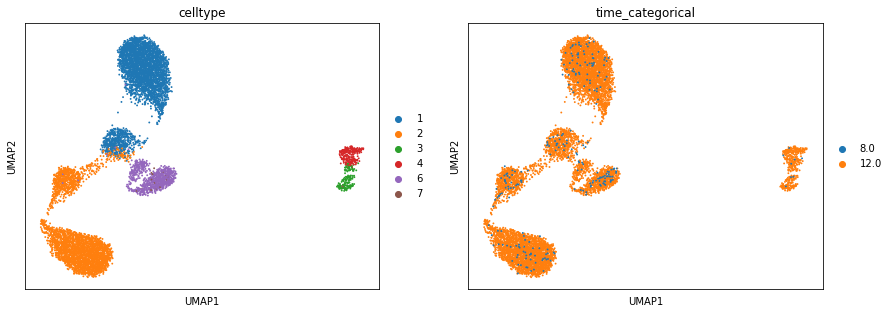

In [8]:
sc.pl.umap(adata, color=["celltype", "time_categorical"])

Apart from the `time_key` we need to set the `joint_attr` which defines where to look for the gene expression data. As we do not have a precomputed embedding, we set it to `None`, as this way PCA will performed on `adata.X`.
If we did not have precomputed cost matrices we could also set the `lineage_attr` to `{"attr": "obsm", "key": "barcodes", "cost": "barcode_distance"}`, which computes the cost matrices based on barcodes.
As we have precomputed cost matrices already, we simply use them.

In [9]:
lp = LineageProblem(adata=adata)
lp = lp.prepare(
    time_key="time",
    joint_attr=None,
    lineage_attr={"attr": "obsp", "key": "cost_matrices"},
)

INFO     Computing pca with `n_comps=30` using `adata.X`                                     


`alpha` determines the influence of the lineage term (between 0 and 1) as opposed to the gene expression. As usual, we choose `epsilon` to be small to get a sparse transport map. 

In [10]:
lp = lp.solve(alpha=0.99, epsilon=1e-3)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(256, 8192)].             


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

## Analyzing cell type transitions

Now, we can compute the descendants of cells at time point 8, aggregated by cell type.

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

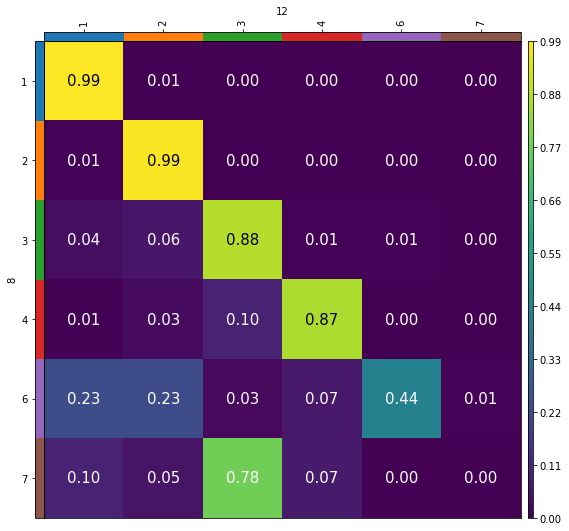

In [11]:
cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups="celltype",
    target_groups="celltype",
    forward=True
)
    
mpl.cell_transition(lp, fontsize=15, figsize=(7,7))

Similarly, we can plot ancestors by setting the parameter `forward` to `False`.

In [12]:
cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups="celltype",
    target_groups="celltype",
    forward=False
)
    
mpl.cell_transition(lp, fontsize=15, figsize=(7,7))

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

Error in callback <function flush_figures at 0x7f5df6022700> (for post_execute):


KeyboardInterrupt: 

Another way to visualize cell type transitions is using a Sankey diagram. We order the annotations explicitly by providing a dictionary for `source_groups` and `target_groups`.

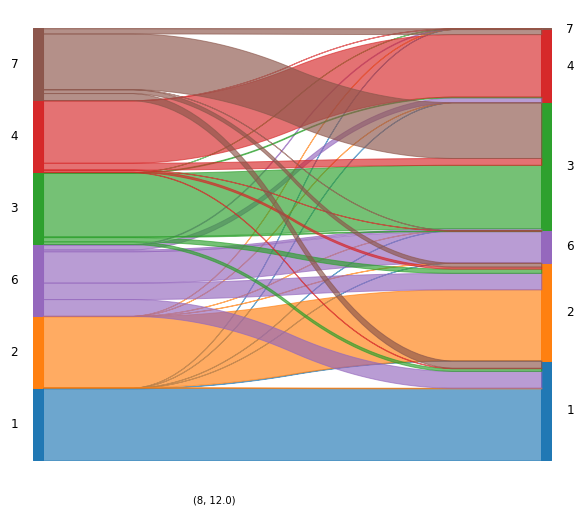

In [13]:
order = ["1", "2", "6", "3", "4", "7"]
lp.sankey(source=8, target=12, source_groups={"celltype": order}, target_groups={"celltype": order})
mpl.sankey(lp, figsize=(8,7))

## Finding subclusters 

Here, we subcluster the relatively large cell type `6`.

In [14]:
sc.tl.leiden(adata, restrict_to=("celltype", ["6"]), resolution=0.4, key_added="celltype_refined")

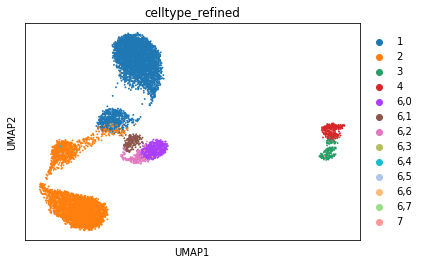

In [15]:
sc.pl.umap(adata, color="celltype_refined")

We are specifically interested where the subclusters of cell type 6 map to, hence we restrict the rows of the transition matrix to the corresponding subclusters. 

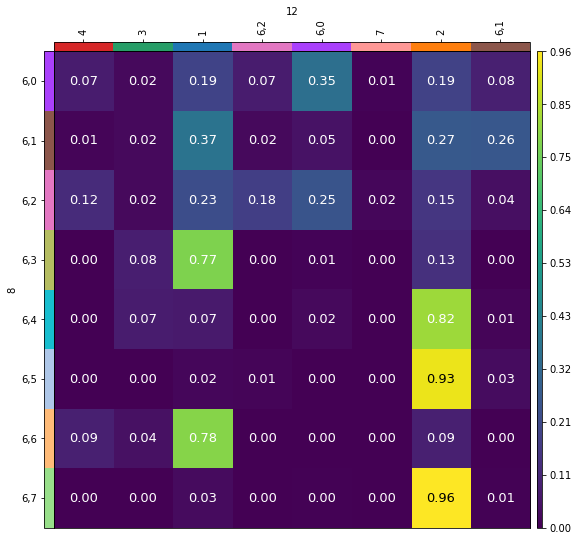

In [16]:
cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups={"celltype_refined": ["6,0", "6,1", "6,2", "6,3", "6,4", "6,5", "6,6", "6,7"]},
    target_groups="celltype_refined",
    forward=True
)
    
mpl.cell_transition(lp, fontsize=13, figsize=(7,7))

We can see that subclusters 6,3 and 6,6 mainly precede cluster 1, while 6,4, 6,5, and 6,7 precede cluster 2. Note that only subcluster 6,0, 6,1, and 6,2 have cells belonging to the later time point.